Importing Dataset from Kaggle:

[Dataset Link](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive)

In [ ]:
!pip install -q kaggle
from google.colab import files

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'hgultekin/bbcnewsarchive'

  0% 0.00/1.81M [00:00<?, ?B/s]
100% 1.81M/1.81M [00:00<00:00, 49.9MB/s]


In [ ]:
! mkdir train

In [ ]:
! unzip bbcnewsarchive.zip -d train

Archive:  bbcnewsarchive.zip
  inflating: train/bbc-news-data.csv  


Importing packages

In [ ]:
import pandas as pd
import nltk
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from gensim.models import Word2Vec
import gensim.downloader as api

import en_core_web_sm
from tqdm import tqdm
import spacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df=pd.read_csv('/content/train/bbc-news-data.csv', sep='\t')
df = df.dropna()
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [ ]:
data = df['content']
data.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2225 entries, 0 to 2224
Series name: content
Non-Null Count  Dtype 
--------------  ----- 
2225 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


#Autoencoder

In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
nlp=en_core_web_sm.load()
sent_vecs={}
docs=[]
for title in tqdm(data):
  doc=nlp(title)
  docs.append(doc)
  sent_vecs.update({title:doc.vector})
sentences=list(sent_vecs.keys())
vectors=list(sent_vecs.values())
vecs=sent_vecs.values()

100%|██████████| 2225/2225 [04:17<00:00,  8.64it/s]


In [ ]:
len(vectors[0])

96

In [ ]:
X_train = np.array([emb for emb in vectors if emb is not None])

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Dense(64, activation='relu'),
      # layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# class Autoencoder(Model):
#     def __init__(self, latent_dim, shape, vocab_size):
#         super(Autoencoder, self).__init__()
#         self.latent_dim = latent_dim
#         self.shape = shape
#         self.vocab_size = vocab_size

#         # Encoder
#         self.encoder = tf.keras.Sequential([
#             layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=shape),
#             layers.LSTM(32, activation='relu', return_sequences=True),
#             layers.LSTM(latent_dim, activation='relu')
#         ])

#         # Decoder
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(shape),
#             layers.LSTM(32, activation='relu', return_sequences=True),
#             layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded


# shape = data.shape[1:]
shape=X_train.shape[1:]
latent_dim = 16
autoencoder = Autoencoder(latent_dim, shape)


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=100, batch_size=256,
                shuffle=True)

Epoch 1/100
9/9 [==============================] - 2s 5ms/step - loss: 0.2791
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2659
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 0.2306
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1708
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 0.1106
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0641
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0386
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0292
Epoch 9/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 10/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0235
Epoch 11/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0229
Epoch 12/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 13/100
9/9 [==============================] - 0s 4ms/st

In [ ]:
encoded_vectors = autoencoder.encoder(X_train).numpy()

In [ ]:
# Define the number of clusters
n_clusters = 5  # Adjust as needed

kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit(encoded_vectors)
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
db_index_ae = davies_bouldin_score(encoded_vectors, cluster_labels)
print(f"Davies-Bouldin index : {db_index_ae}")
ch_score_ae = calinski_harabasz_score(encoded_vectors, cluster_labels)
print("Calinski-Harabasz Index:", ch_score_ae)

Davies-Bouldin index : 0.8967981610882818
Calinski-Harabasz Index: 1250.820818393554


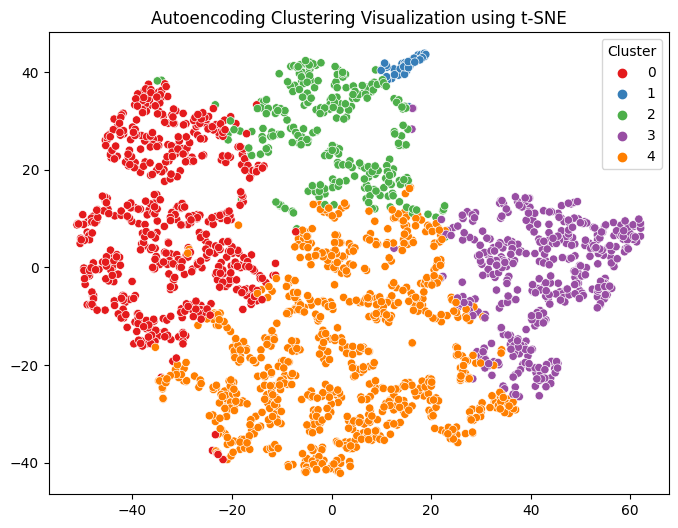

In [ ]:
# Perform t-SNE dimensionality reduction on embeddings
X_tsne_ae = TSNE(n_components=2, random_state=42).fit_transform(encoded_vectors)

# Visualize the t-SNE projections with BERT clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne_ae[:, 0],
    y=X_tsne_ae[:, 1],
    hue=cluster_labels,
    palette='Set1',
    legend='full'
)
plt.title('Autoencoding Clustering Visualization using t-SNE')
plt.legend(title='Cluster')
plt.show()


In [ ]:
from collections import defaultdict

# Create a dictionary to store indices of vectors belonging to each cluster
cluster_indices = defaultdict(list)
for idx, label in enumerate(cluster_labels):
    cluster_indices[label].append(idx)

# Display some samples from each cluster
num_samples = 5  # Number of samples to display per cluster

for cluster_id, indices in cluster_indices.items():
    print(f"Cluster {cluster_id}:")
    samples = min(num_samples, len(indices))
    for i in range(samples):
        idx = indices[i]
        # You can display the contents or properties of the vector here
        # For example, if 'encoded_vectors' contains embeddings, you can print them
        print(data[idx])
    print("-----------")

Cluster 0:
 Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.  Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers f

# Autoencoder + One hot Encoding


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow
# from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import optimizers
from tensorflow.python.keras import layers

In [ ]:
tk = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n')

tk.fit_on_texts(data)

# + 1 for unknown token
vocab_size = len(tk.word_index) +1

X_train_seq = tk.texts_to_sequences(data)
# Initializing max length of sentence to 20 words
max_length = 1000

In [ ]:
tk.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'in': 6,
 'for': 7,
 'is': 8,
 'that': 9,
 'on': 10,
 'said': 11,
 'it': 12,
 'was': 13,
 'be': 14,
 'he': 15,
 'with': 16,
 'as': 17,
 'has': 18,
 'have': 19,
 'at': 20,
 'by': 21,
 'will': 22,
 'but': 23,
 'are': 24,
 'from': 25,
 'not': 26,
 'i': 27,
 'his': 28,
 'mr': 29,
 'they': 30,
 'this': 31,
 'an': 32,
 'we': 33,
 'which': 34,
 'had': 35,
 'would': 36,
 'been': 37,
 'their': 38,
 'more': 39,
 'its': 40,
 'up': 41,
 'were': 42,
 'also': 43,
 'year': 44,
 'who': 45,
 'people': 46,
 'new': 47,
 'one': 48,
 'us': 49,
 'about': 50,
 'there': 51,
 'after': 52,
 'out': 53,
 'or': 54,
 'than': 55,
 'all': 56,
 'can': 57,
 'if': 58,
 'could': 59,
 'you': 60,
 'over': 61,
 'last': 62,
 'first': 63,
 'when': 64,
 'time': 65,
 'two': 66,
 'so': 67,
 'now': 68,
 'other': 69,
 'some': 70,
 'into': 71,
 'what': 72,
 'she': 73,
 'government': 74,
 'world': 75,
 'years': 76,
 'them': 77,
 'against': 78,
 'best': 79,
 'no': 80,
 'only': 81,
 

In [ ]:
vocab_size

31842

In [ ]:
#padding the sequences to make all the input sequences of the same length

X_train_seq_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')

In [ ]:
X_train_seq_pad

array([[ 4003,   680,    20, ...,     0,     0,     0],
       [    1,   486,    18, ...,     0,     0,     0],
       [    1,  1973,     3, ...,     0,     0,     0],
       ...,
       [   25,   302,  2681, ...,   456,   144,   228],
       [    1,   398,   282, ...,     0,     0,     0],
       [   23,    31,  1390, ...,     1,   370, 31841]], dtype=int32)

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      # layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='relu'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# class Autoencoder(Model):
#     def __init__(self, latent_dim, shape, vocab_size):
#         super(Autoencoder, self).__init__()
#         self.latent_dim = latent_dim
#         self.shape = shape
#         self.vocab_size = vocab_size

#         # Encoder
#         self.encoder = tf.keras.Sequential([
#             layers.Embedding(input_dim=vocab_size, output_dim=64, input_length=shape),
#             layers.LSTM(32, activation='relu', return_sequences=True),
#             layers.LSTM(latent_dim, activation='relu')
#         ])

#         # Decoder
#         self.decoder = tf.keras.Sequential([
#             layers.RepeatVector(shape),
#             layers.LSTM(32, activation='relu', return_sequences=True),
#             layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
#         ])

#     def call(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded


# shape = data.shape[1:]
shape=X_train_seq_pad.shape[1:]
latent_dim = 16
autoencoder = Autoencoder(latent_dim, shape)


In [ ]:
# autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(X_train_seq_pad, X_train_seq_pad,
                epochs=100, batch_size=256,
                shuffle=True)

Epoch 1/100
9/9 [==============================] - 2s 14ms/step - loss: -915.1924
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: -2526.3420
Epoch 3/100
9/9 [==============================] - 0s 16ms/step - loss: -3673.0107
Epoch 4/100
9/9 [==============================] - 0s 16ms/step - loss: -4554.9541
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: -5287.8823
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: -5737.3306
Epoch 7/100
9/9 [==============================] - 0s 12ms/step - loss: -5976.6074
Epoch 8/100
9/9 [==============================] - 0s 15ms/step - loss: -6118.8916
Epoch 9/100
9/9 [==============================] - 0s 17ms/step - loss: -6175.2236
Epoch 10/100
9/9 [==============================] - 0s 17ms/step - loss: -6251.5703
Epoch 11/100
9/9 [==============================] - 0s 16ms/step - loss: -6341.6226
Epoch 12/100
9/9 [==============================] - 0s 16ms/step - loss: -6428.7847
Ep

In [ ]:
encoded_vectors = autoencoder.encoder(X_train_seq_pad).numpy()

In [ ]:
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 5  # Adjust as needed

kmeans = KMeans(n_clusters=n_clusters)
cluster_labels = kmeans.fit(encoded_vectors)
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
db_index_ae = davies_bouldin_score(encoded_vectors, cluster_labels)
print(f"Davies-Bouldin index : {db_index_ae}")
ch_score_ae = calinski_harabasz_score(encoded_vectors, cluster_labels)
print("Calinski-Harabasz Index:", ch_score_ae)

Davies-Bouldin index : 0.8288875979606025
Calinski-Harabasz Index: 3298.1962736041146


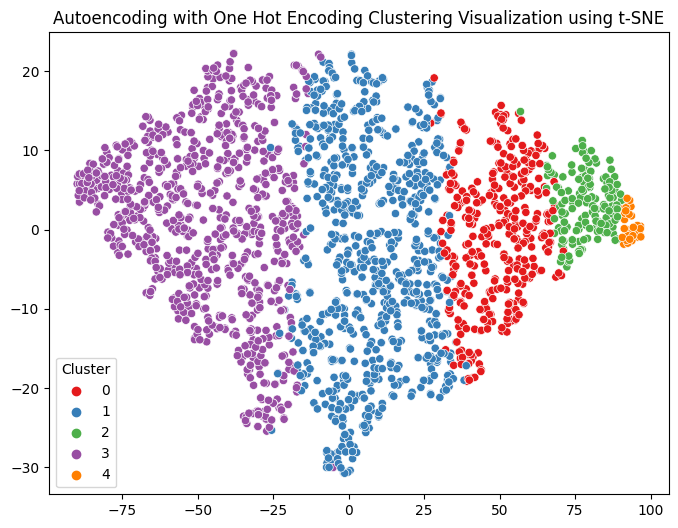

In [ ]:
# Perform t-SNE dimensionality reduction on embeddings
X_tsne_aeh = TSNE(n_components=2, random_state=42).fit_transform(encoded_vectors)

# Visualize the t-SNE projections with clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_tsne_aeh[:, 0],
    y=X_tsne_aeh[:, 1],
    hue=cluster_labels,
    palette='Set1',
    legend='full'
)
plt.title('Autoencoding with One Hot Encoding Clustering Visualization using t-SNE')
plt.legend(title='Cluster')
plt.show()